<a href="https://colab.research.google.com/github/febriyansyahresearch-lab/Research/blob/main/data-mining/sentiment-analysis/SentimenAnalisisTrump.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

⚠️ Weird header -> reload header=None | encoding=cp1252 | shape=(21, 7)
📝 Text column used: 0
Top candidates: [(0, (21, 66.52380952380952, 0.8169571057560843)), (1, (18, 98.66666666666667, 0.7898268290475277)), (2, (9, 97.88888888888889, 0.7754007211937402)), (3, (5, 68.6, 0.800462585311472)), (4, (3, 64.0, 0.7959854959854958))]
✅ Token count: 102


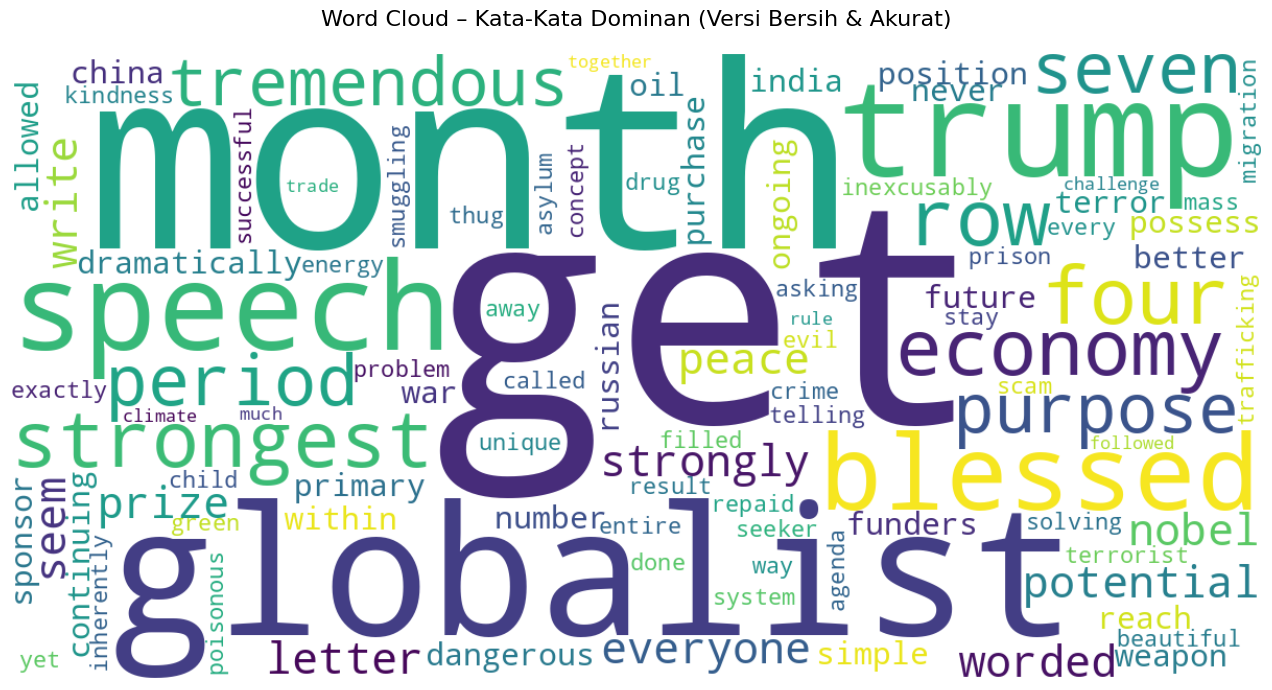

,word,count
0,get,3
1,month,2
2,globalist,2
3,trump,1
4,speech,1
5,blessed,1
6,strongest,1
7,economy,1
8,four,1
9,row,1


In [8]:
# =========================================================
# FULL VERSION (ROBUST): Clean WordCloud - NO punkt dependency
# Input: /mnt/data/Trump-UN.csv
# =========================================================

!pip -q install pandas numpy matplotlib wordcloud nltk

import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from collections import Counter

nltk.download("stopwords", quiet=True)
nltk.download("wordnet", quiet=True)
nltk.download("omw-1.4", quiet=True)
from nltk.stem import WordNetLemmatizer

FILE_PATH = "/mnt/data/Trump-UN.csv"

# -------------------------
# 1) LOAD CSV (smart header + encoding)
# -------------------------
def load_csv_smart(path: str) -> pd.DataFrame:
    if not os.path.exists(path):
        raise FileNotFoundError(f"File tidak ditemukan: {path}")

    encodings = ["utf-8", "utf-8-sig", "cp1252", "latin1"]
    last_err = None

    for enc in encodings:
        try:
            df_try = pd.read_csv(path, encoding=enc, on_bad_lines="skip")
            # detect weird header
            if len(df_try.columns) > 0 and max(len(str(c)) for c in df_try.columns) > 60:
                df_try = pd.read_csv(path, encoding=enc, on_bad_lines="skip", header=None)
                print(f"⚠️ Weird header -> reload header=None | encoding={enc} | shape={df_try.shape}")
            else:
                print(f"✅ CSV loaded | encoding={enc} | shape={df_try.shape}")
            return df_try
        except Exception as e:
            last_err = e

    df = pd.read_csv(path, encoding="latin1", on_bad_lines="skip", header=None)
    print(f"✅ CSV fallback latin1 header=None | shape={df.shape} | last_err={last_err}")
    return df

df = load_csv_smart(FILE_PATH)

# -------------------------
# 2) PICK BEST TEXT COLUMN
# -------------------------
def pick_text_column(df: pd.DataFrame):
    cols = list(df.columns)

    def score_col(c):
        s = df[c].dropna().astype(str)
        if len(s) == 0:
            return (-1, -1, -1)
        avg_len = s.map(len).mean()
        alpha_ratio = s.map(lambda x: sum(ch.isalpha() for ch in x) / max(1, len(x))).mean()
        return (len(s), float(avg_len), float(alpha_ratio))

    scored = [(c, score_col(c)) for c in cols]
    scored.sort(key=lambda x: x[1], reverse=True)
    return scored[0][0], scored[:5]

text_col, top5 = pick_text_column(df)
print("📝 Text column used:", text_col)
print("Top candidates:", top5)

texts = df[text_col].dropna().astype(str).tolist()
full_text = " ".join(texts)

# -------------------------
# 3) CLEAN + TOKENIZE (REGEX, NO punkt)
# -------------------------
stop_en = set(stopwords.words("english"))
stop_id = set(stopwords.words("indonesian"))

custom_stop = {
    # filler pidato
    "today","now","here","thank","thanks","mr","madam","sir","ladies","gentlemen",
    "applause","welcome","honor","honored","distinguished",
    "also","very","really","just","one","two","three","first","second",
    "said","say","says","tell","tells","make","makes","made","going","want","need",

    # terlalu umum
    "people","country","countries","nation","nations","world","global",
    "leaders","leader","government","governments",

    # UN/US terms terlalu dominan
    "united","states","america","american","un","unitednations",
    "assembly","general","session","remarks","president",

    # noise
    "watch","video","live","full","highlight","highlights",
    # common weak words
    "year","years","also","will","would","could","must"
}
STOP = stop_en | stop_id | custom_stop

lemmatizer = WordNetLemmatizer()

def preprocess(text: str):
    text = text.replace("\xa0", " ")
    text = re.sub(r"https?://\S+|www\.\S+", " ", text)
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()

    # regex tokenization
    tokens = re.findall(r"[a-z]{3,}", text)  # minimal 3 huruf
    tokens = [t for t in tokens if t not in STOP]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    tokens = [t for t in tokens if t not in STOP]  # filter ulang setelah lemmatize
    return tokens

tokens = preprocess(full_text)
print("✅ Token count:", len(tokens))

# -------------------------
# 4) WORDCLOUD (like your example)
# -------------------------
freq = Counter(tokens)

wc = WordCloud(
    width=1200,
    height=600,
    background_color="white",
    max_words=250,
    collocations=False
).generate_from_frequencies(freq)

plt.figure(figsize=(14,7))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud – Kata-Kata Dominan (Versi Bersih & Akurat)", fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# -------------------------
# 5) TOP WORDS (validasi cepat)
# -------------------------
pd.DataFrame(freq.most_common(30), columns=["word", "count"])
